In [2]:
#!conda install --yes tensorflow-datasets
#!conda install --yes matplotlib
#!conda install --yes seaborn
#!conda install --yes scipy
#!conda install -c conda-forge opencv
#!conda install --yes glob
#!conda install --yes scikit-image
#!pip install opencv-python
#!pip install imutils
#!pip install kaggle --upgrade
#!pip install tqdm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance as dist
import os
import cv2
from skimage.filters import gaussian
from skimage.morphology import dilation,erosion
from skimage.feature import canny
from skimage.measure import find_contours
import imutils
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

print("pass all package")

pass all package


In [4]:
os.environ['KAGGLE_USERNAME'] = 'hongyielsuh'
os.environ['KAGGLE_KEY'] = '6cc8b1fd26df2be653b31439180c58d7'
!kaggle -h

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        config {view, set, unset}
    competitions (c)    Commands related to Kaggle competitions
    datasets (d)        Commands related to Kaggle datasets
    kernels (k)         Commands related to Kaggle kernels
    config              Configuration settings


In [5]:
def findedges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

In [6]:
def getimageconturs(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

In [7]:
def getboxes(contours,orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

In [8]:
#!kaggle datasets download -d paultimothymooney/blood-cells

In [9]:
!ls

 1.png
 2.png
 3.png
'CNN_testing_blood_cell_ Inception.ipynb'
 CNN_testing_blood_cell_CNN.ipynb
 CNN_testing_blood_cell_ResNet.ipynb
 CNN_testing_blood_cell_ResNet_fine_tuing.ipynb
 CNN_testing_blood_cell_VGG_90ab.ipynb
 CNN_testing_blood_cell_VGG_90ab_Dt_transform.ipynb
 CNN_testing_blood_cell_keras_InceptionV3_made.ipynb
 CNN_testing_blood_cell_keras_ResNet50_made.ipynb
 CNN_testing_blood_cell_keras_VGG16_made.ipynb
 CNN_testing_blood_cell_keras_VGG19_made.ipynb
 CNN_testing_blood_cell_mobilenetv2_90ab.ipynb
 CNN_testing_blood_cell_mobilenetv2_transform.ipynb
 CNN_testing_blood_cell_origin_not_workingcurrently.ipynb
 Cat03.jpeg
 FinedTuned_ResNet50.ipynb
 Running_model.ipynb
 Testing.ipynb
 Vision_Transformer_with_bio_data.ipynb
 Vision_testing_bio.ipynb
 blood-cells.zip
 content
 data_transforming_test.ipynb
 dataset-master
 dataset2-master
 dataset3-master
 enter
 gpf.ipynb
 model.png
 model_analysis.ipynb
 models
 result_custom_vgg19.h5
 result_resnet50_pure.h5
 result_transforme

In [10]:
#!unzip '*.zip'
#!pwd

In [11]:
image_size=(120,120)
code={"EOSINOPHIL":0,"LYMPHOCYTE":1,"MONOCYTE":2,"NEUTROPHIL":3}
def getcode(n):
    if type(n)==str:
        for x,y in code.items():
            if n==x:
                return y 
    else:
        for x,y in code.items():
            if n==y:
                return x

In [12]:
!pwd
import os
import time
import glob as gb

from tqdm import tqdm

current_directory = os.getcwd()
def loaddata():
    datasets=[current_directory + "/dataset2-master/dataset2-master/images/TRAIN/",
          current_directory + "/dataset2-master/dataset2-master/images/TEST/",]
    
    images=[]
    labels=[]
    count=0
    
    for dataset in datasets:        
        for folder in os.listdir(dataset):
            

            files=gb.glob(pathname=str(dataset+folder+"/*.jpeg"))
            label=getcode(folder)
            for file in tqdm(files):
                time.sleep(0.1)
                
                
                image = cv2.imread(file)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # add padding to the image to better detect cell at the edge
                image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
                
                #thresholding the image to get the target cell
                image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
                
                # openning errosion then dilation
                kernel = np.ones((3, 3), np.uint8)
                kernel1 = np.ones((5, 5), np.uint8)
                img_erosion = cv2.erode(image1, kernel, iterations=2)
                image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
                
                #detecting the blood cell
                edgedImage = findedges(image1)
                edgedContours = getimageconturs(edgedImage)
                edgedBoxes =  getboxes(edgedContours, image.copy())
                if len(edgedBoxes)==0:
                    count +=1
                    continue
                # get the large box and get its cordinate
                last = edgedBoxes[-1]
                max_x = int(max(last[:,0]))
                min_x = int( min(last[:,0]))
                max_y = int(max(last[:,1]))
                min_y = int(min(last[:,1]))
                
                # draw the contour and fill it 
                mask = np.zeros_like(image)
                cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                
                # any pixel but the pixels inside the contour is zero
                image[mask==0] = 0
                
                # extract th blood cell
                image = image[min_y:max_y, min_x:max_x]

                if (np.size(image)==0):
                    count +=1
                    continue
                # resize th image
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
                
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')
    
    return images,labels

/home/hisuh/dt


In [13]:
images,labels=loaddata()

100%|█████████████████████████████████████████████████████| 623/623 [01:07<00:00,  9.19it/s]


In [14]:
images,labels=shuffle(images,labels,random_state=10)

In [15]:
images=images/255
train_image,test_image,train_label,test_label=train_test_split(images,labels,test_size=.2)
test_image,val_image,test_label,val_label=train_test_split(test_image,test_label,test_size=.5)

In [16]:
def displayrandomimage(image,label,typeofimage):
    plt.figure(figsize=(15,15))
    plt.suptitle("some random image of "+typeofimage,fontsize=17)
    for n,i in  enumerate(list(np.random.randint(0,len(image),36))):
        plt.subplot(6,6,n+1)
        plt.imshow(image[i])
        plt.axis("off")
        plt.title(getcode(label[i]))

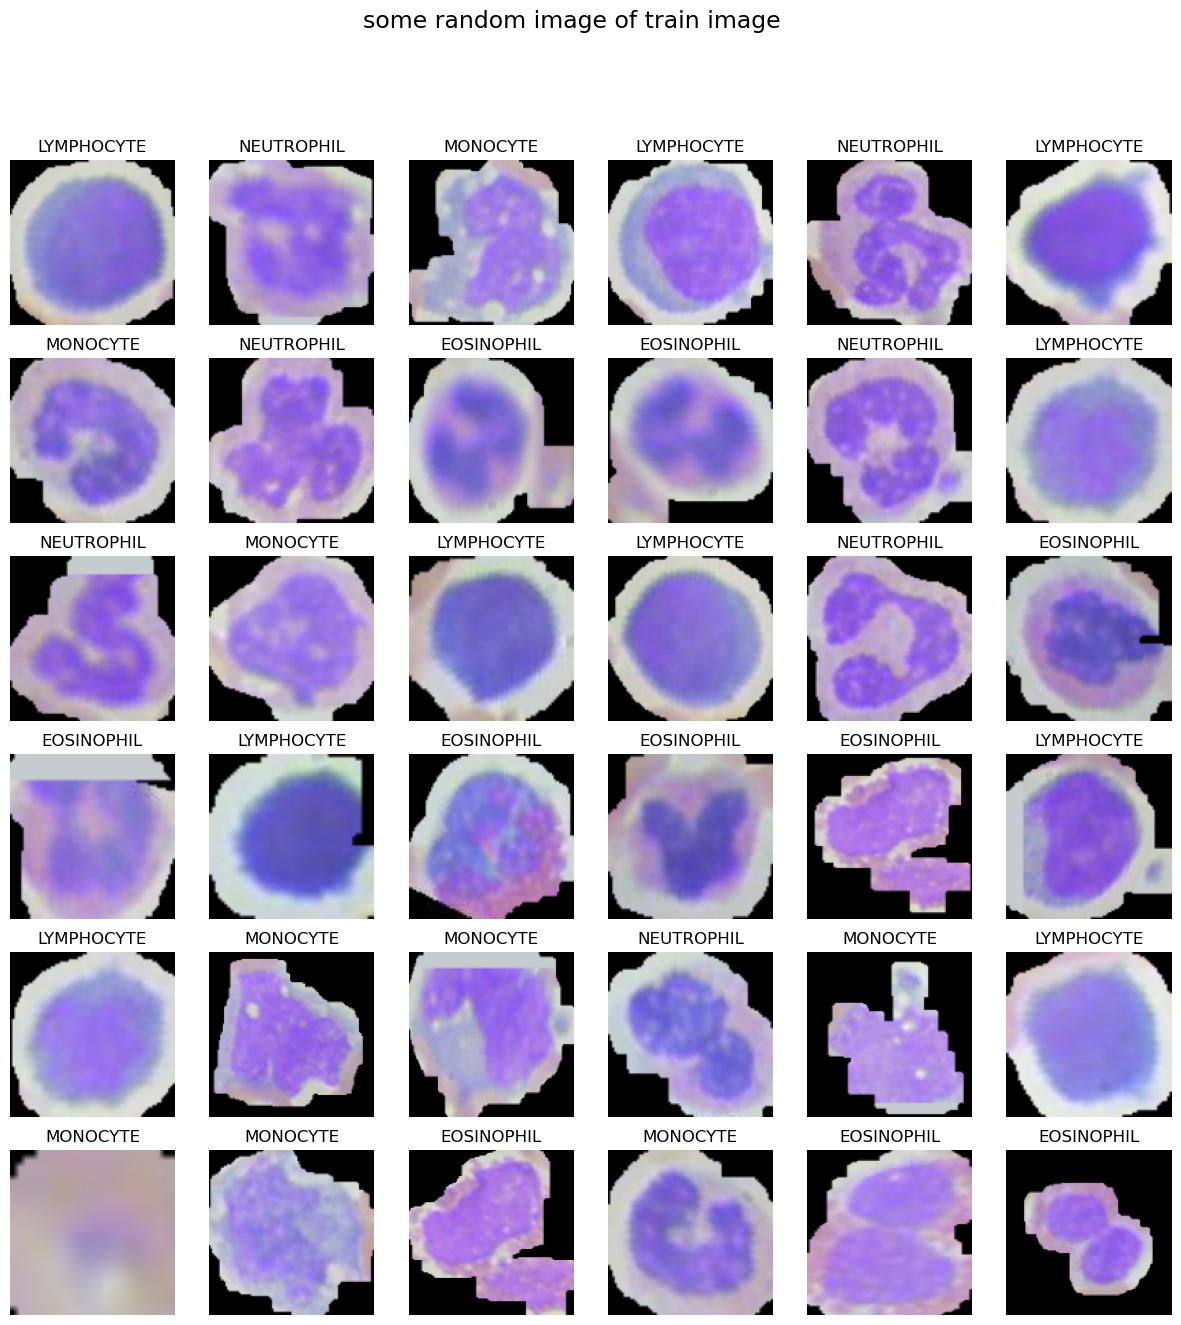

In [17]:
displayrandomimage(train_image,train_label,"train image")

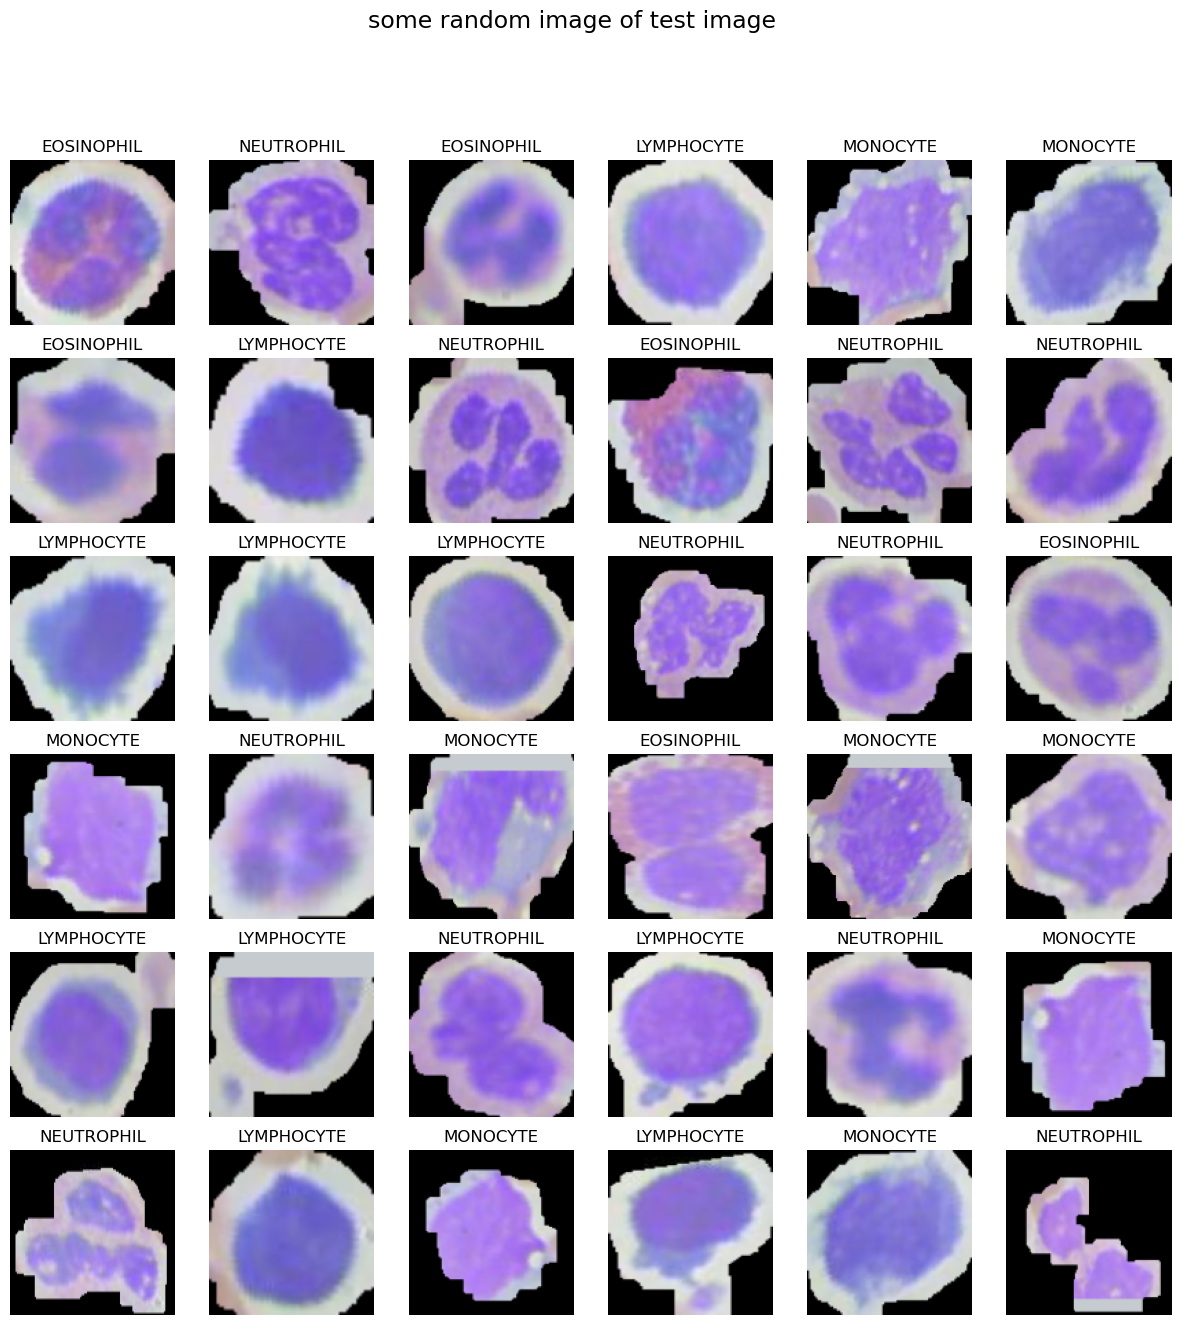

In [18]:
displayrandomimage(test_image,test_label,"test image")

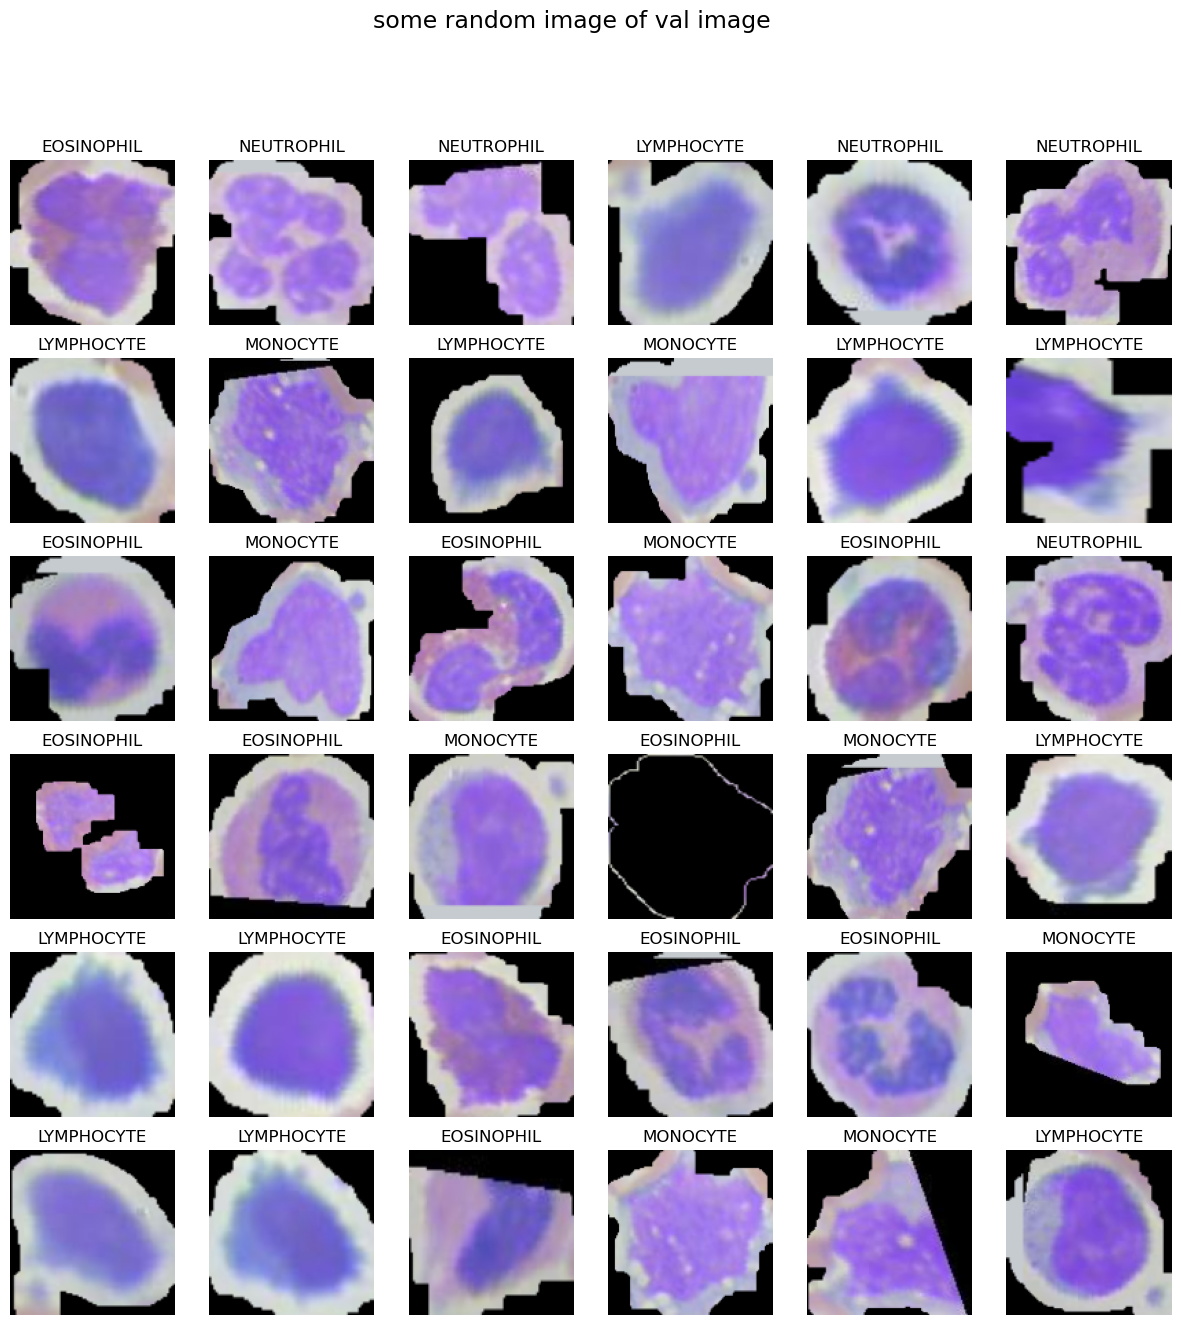

In [19]:
displayrandomimage(val_image,val_label,"val image")

x_train shape: (9716, 120, 120, 3) - y_train shape: (9716,)
x_test shape: (1215, 120, 120, 3) - y_test shape: (1215,)


2022-12-26 14:10:53.241352: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-26 14:10:55.296425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11558 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:0a:00.0, compute capability: 3.7
2022-12-26 14:10:55.297805: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11558 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:0b:00.0, compute capability: 3.7
2022-12-26 14:10:55.299008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 11558 MB m

72
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


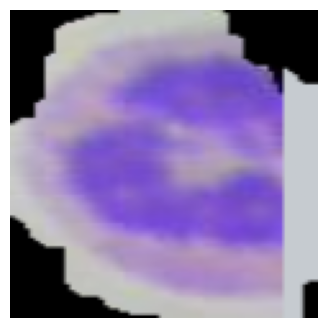

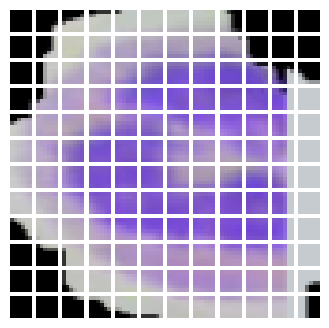

In [20]:
import keras
from keras import models
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
import keras.backend as K

import tensorflow as tf
from keras import layers, models
# from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
# from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


num_classes = 4
input_shape = (120, 120, 3)

# learning_rate = 0.005
# weight_decay = 0.0005
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4


transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


(x_train, y_train), (x_test, y_test) = (train_image, train_label) , (test_image, test_label)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
# Configurre the hyperparameters


data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_image)

# Implement multilayer perceptron(MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implement patch creation as a layers

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    

# image = train_image[np.random.choice(range(train_image.shape[0]))]
# plt.imshow(image)

plt.figure(figsize=(4, 4))
image = train_image[np.random.choice(range(train_image.shape[0]))]
plt.imshow(image)
plt.axis("off")

print(image_size)

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")


In [21]:
#!pip install -U tensorflow-addons
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [24]:
from keras.models import load_model

def create_vit_classifier(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,):
    
    inputs = layers.Input(shape=input_shape)
#     Augment data.
    augmented = data_augmentation(inputs)
#     Create patches.
    patches = Patches(patch_size)(augmented)
#     Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    
    
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=train_image,
        y=train_label,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
#         callbacks=[checkpoint_callback],
    )
    
    print(train_image)
    print(train_label)

#     model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test_image, test_label)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    
    return history, model
num_epochs = 1



print(input_shape)
print(patch_size)
print(num_patches)
print(projection_dim)
print(num_heads)
print(transformer_units)
print(transformer_layers)
print(mlp_head_units)


vit_classifier = create_vit_classifier(input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,)
history, model = run_experiment(vit_classifier,learning_rate, weight_decay, batch_size, num_epochs)
print(model)
print(history)
# model.save('result_vit_model.h5')

(120, 120, 3)
6
144
64
4
[128, 64]
8
[2048, 1024]
35/35 [==============================] - 37s 807ms/step - loss: 3.0479 - accuracy: 0.3934 - top-5-accuracy: 1.0000 - val_loss: 1.1022 - val_accuracy: 0.5216 - val_top-5-accuracy: 1.0000
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0

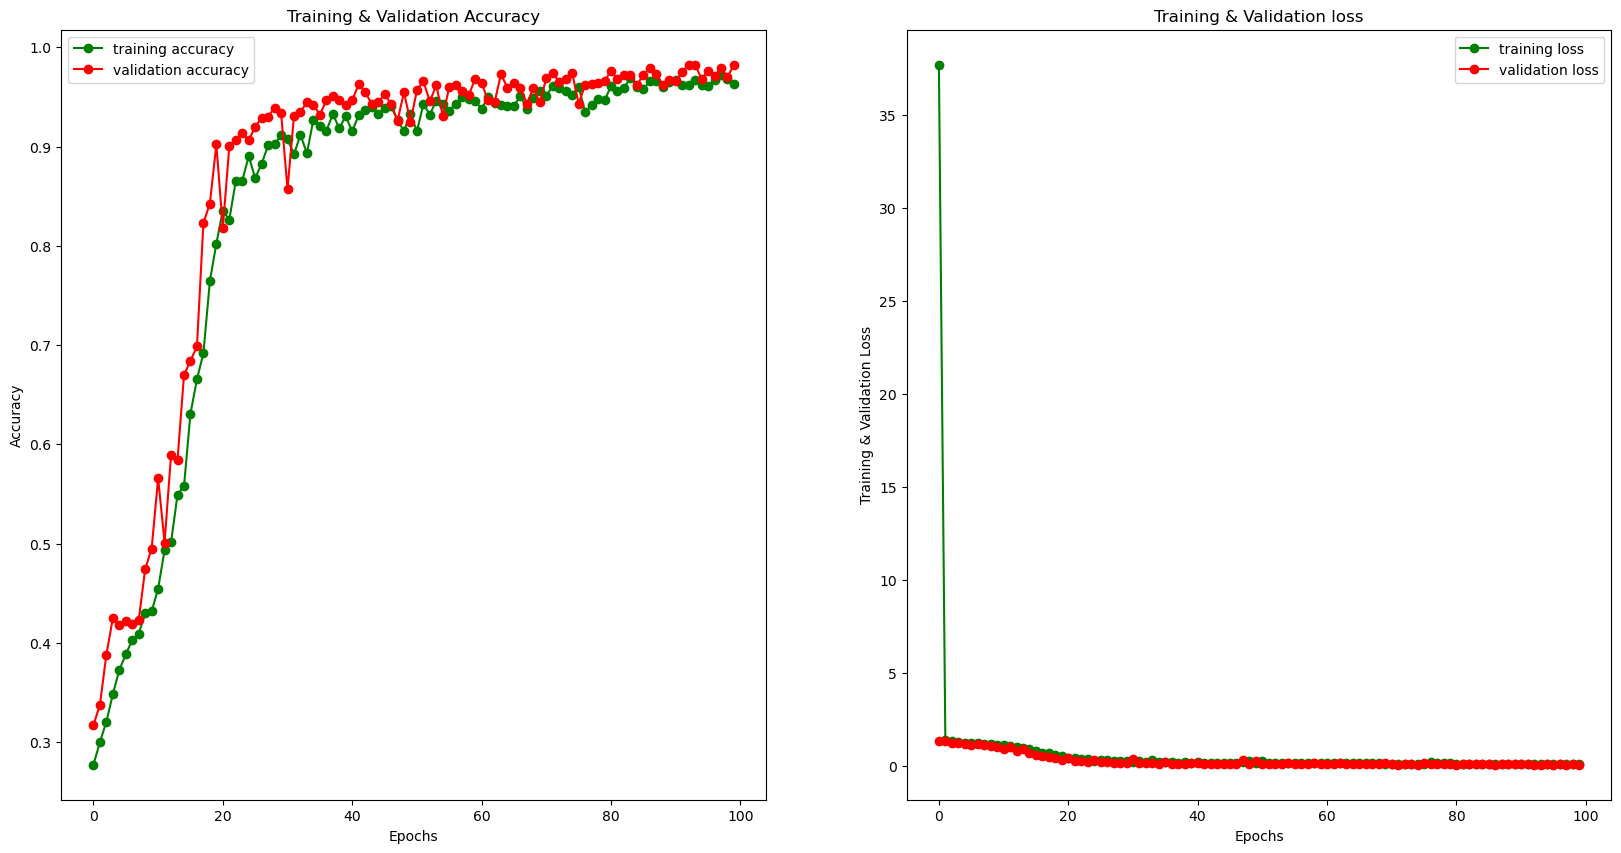

In [43]:
# loss,acc=model.evaluate(test_image,test_label)

# print("the accuracy of test image is : ",accuracy)

def plot_acc_and_loss_of_train_and_val(history):
    #plt.figure(figsize=(15,15))
    #plt.suptitle("acc,loss of train VS acc,loss of val")
    epochs=[i for i in range(100)]
    train_acc=history.history['accuracy']
    train_loss=history.history['loss']
    val_acc=history.history['val_accuracy']
    val_loss=history.history['val_loss']
    fig , ax=plt.subplots(1,2)
    fig.set_size_inches(20,10)
    ax[0].plot(epochs,train_acc,'go-',label='training accuracy')
    ax[0].plot(epochs,val_acc,'ro-',label='validation accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epochs,train_loss,'g-o',label='training loss')
    ax[1].plot(epochs,val_loss,'r-o',label='validation loss')
    ax[1].set_title('Training & Validation loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")

    
plot_acc_and_loss_of_train_and_val(history)



(9716, 120, 120, 3)
(9716,)
(1215, 120, 120, 3)
(1215,)


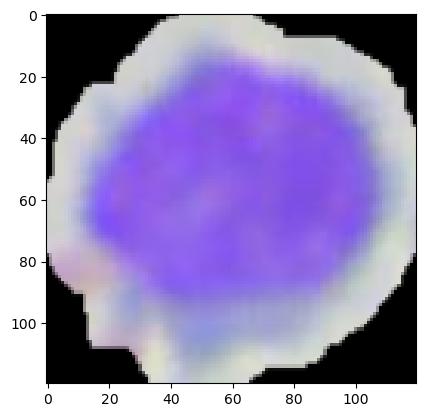

In [33]:
print(train_image.shape)
print(train_label.shape)

print(test_image.shape)
print(test_label.shape)


# image_tmp = train_image[np.random.choice(range(train_image.shape[0]))]
# plt.imshow(image_tmp)

image_tmp = test_image[np.random.choice(range(test_image.shape[0]))]
plt.imshow(image_tmp)



In [34]:
#!pip install transformers
# def get_config(self):

#         config = super().get_config().copy()
#         config.update({
#             'vocab_size': self.vocab_size,
#             'num_layers': self.num_layers,
#             'units': self.units,
#             'd_model': self.d_model,
#             'num_heads': self.num_heads,
#             'dropout': self.dropout,
#         })
#         return config
print("??")
model.save('result_vi_fix_ver1.h5')



??


['/home/hisuh/dt/dataset2-master/images/TRAIN/NEUTROPHIL//_0_2400.jpeg']


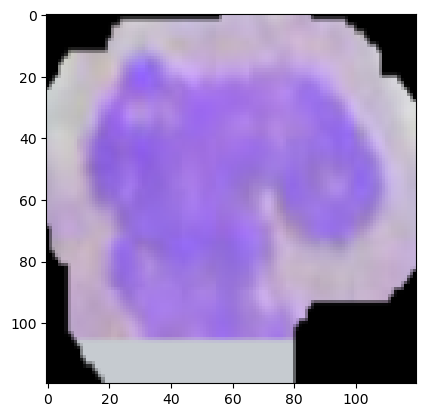

['-10.352316856', '15.093821526', '4.400657177', '-0.883314013']


In [39]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

def getboxes(contours,orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

image_size=(120,120)
def findedges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged
def getimageconturs(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance as dist
import os
import cv2
import glob as gb
from skimage.filters import gaussian
from skimage.morphology import dilation,erosion
from skimage.feature import canny
from skimage.measure import find_contours
import imutils
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

current_directory = os.getcwd()

# testing origin data
datasets= current_directory + "/dataset2-master/images/TRAIN/NEUTROPHIL/"
files =gb.glob(pathname=str(datasets + "/_0_2400.jpeg"))

# files =gb.glob(pathname=str(datasets + "/_12_5618.jpeg"))

# testing new data

print(files)
images = []

for file in files:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
    # add padding to the image to better detect cell at the edge
    image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
                
    #thresholding the image to get the target cell
    image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
                
    # openning errosion then dilation
    kernel = np.ones((3, 3), np.uint8)
    kernel1 = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(image1, kernel, iterations=2)
    image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
                
    #detecting the blood cell
    edgedImage = findedges(image1)
    edgedContours = getimageconturs(edgedImage)
    edgedBoxes =  getboxes(edgedContours, image.copy())
    if len(edgedBoxes)==0:
        count +=1
        continue
    # get the large box and get its cordinate
    last = edgedBoxes[-1]
    max_x = int(max(last[:,0]))
    min_x = int( min(last[:,0]))
    max_y = int(max(last[:,1]))
    min_y = int(min(last[:,1]))
                
    # draw the contour and fill it 
    mask = np.zeros_like(image)
    cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                
    # any pixel but the pixels inside the contour is zero
    image[mask==0] = 0
                
    # extract th blood cell
    image = image[min_y:max_y, min_x:max_x]

    if (np.size(image)==0):
        count +=1
        continue
    # resize th image
    image = cv2.resize(image, image_size)
    images.append(image)
    
    plt.imshow(image)
    plt.show()
    
images = np.array(images, dtype = 'float32')
# load model
model2 = keras.models.load_model('result_vi.h5',custom_objects={'Patches':Patches, 'PatchEncoder':PatchEncoder})

y_prob = model2.predict(images)
predicted = y_prob.argmax(axis=-1)
a = []
for i in y_prob:
    for j in i:
        t = '{:.9f}'.format(j)
        a.append(t)
        
print(a)